In [1]:
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
%matplotlib inline

C:\Users\Shyamprasad\Anaconda3\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [2]:
data = pd.read_csv('case_Study_032019.csv', index_col=['f1','f2','f3','f4','f5','f6', 'f7'])

In [3]:
data.head()

,,,,,,,target
f1,f2,f3,f4,f5,f6,f7,
9347.14,700.004090,208.734380,7,954976,9140,76810,12577612.45
9141.69,705.182962,203.127791,0,146993,8791,59183,11582947.44
9561.76,703.794276,202.746595,0,402416,5124,31203,12528536.47
9340.60,707.865745,203.925955,0,778496,2758,54204,13731486.78
9391.46,709.130852,202.010619,0,573005,7051,22376,14136811.35


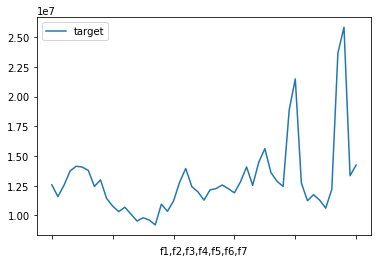

In [4]:
data.plot()

# Train Test Split

In [5]:
data.info()

<class 'pandas.core.frame.DataFrame'>
MultiIndex: 51 entries, (9347.14, 700.0040896, 208.7343801, 7, 954976, 9140, 76810) to (9874.2, 306.63810789999997, 204.0777415, 0, 425708, 9508, 22263)
Data columns (total 1 columns):
target    51 non-null float64
dtypes: float64(1)
memory usage: 3.4 KB


We have total of 51 rows, Here I am Taking last 30% rows as test data

In [6]:
(51/100)*30

15.3

In [7]:
51-15

36

So here Iam taking last 15 rows as testing data

In [8]:
train_set = data.head(36)

In [9]:
test_set = data.tail(15)

### Scale the Data

In [10]:
from sklearn.preprocessing import MinMaxScaler

In [11]:
scaler = MinMaxScaler()

In [12]:
train_scaled = scaler.fit_transform(train_set)

In [13]:
test_scaled = scaler.transform(test_set)

## Batch Function

In [14]:
def next_batch(training_data,batch_size,steps):
    
    
    # For a random starting point for each batch
    rand_start = np.random.randint(0,len(training_data)-steps) 

    # Create Y data for  series in the batches
    y_batch = np.array(training_data[rand_start:rand_start+steps+1]).reshape(1,steps+1)

    return y_batch[:, :-1].reshape(-1, steps, 1), y_batch[:, 1:].reshape(-1, steps, 1) 

## Setting Up The RNN Model

In [15]:
# Just one feature, the series
num_inputs = 1
# Num of steps in each batch
num_time_steps = 15
# 100 neuron layer, play with this
num_neurons = 100
# output to be predicted 
num_outputs = 1

# learning rate 
learning_rate = 0.03 
# how many iterations to go through (training steps)
num_train_iterations = 4000
# Size of the batch of data
batch_size = 1

Create Placeholders for X and y.

In [16]:
X = tf.placeholder(tf.float32, [None, num_time_steps, num_inputs])
y = tf.placeholder(tf.float32, [None, num_time_steps, num_outputs])

In [17]:
# Also play around with GRUCell
cell = tf.contrib.rnn.OutputProjectionWrapper(
    tf.contrib.rnn.BasicLSTMCell(num_units=num_neurons, activation=tf.nn.relu),
    output_size=num_outputs) 

Instructions for updating:
This class is deprecated, please use tf.nn.rnn_cell.LSTMCell, which supports all the feature this cell currently has. Please replace the existing code with tf.nn.rnn_cell.LSTMCell(name='basic_lstm_cell').


** Now pass in the cells variable into tf.nn.dynamic_rnn, along with your first placeholder (X)**

In [18]:
outputs, states = tf.nn.dynamic_rnn(cell, X, dtype=tf.float32)

### Loss Function and Optimizer

** Creating a Mean Squared Error Loss Function and use it to minimize an AdamOptimizer **

In [19]:
loss = tf.reduce_mean(tf.square(outputs - y)) # MSE
optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate)
train = optimizer.minimize(loss)

** Initialize the global variables **

In [20]:
init = tf.global_variables_initializer()

** Create an instance of tf.train.Saver() **

In [21]:
saver = tf.train.Saver()

### Session

** Run a tf.Session that trains on the batches created by your next_batch function. 

In [22]:
gpu_options = tf.GPUOptions(per_process_gpu_memory_fraction=0.9)

In [34]:
with tf.Session(config=tf.ConfigProto(gpu_options=gpu_options)) as sess:
    sess.run(init)
    
    for iteration in range(num_train_iterations):
        
        X_batch, y_batch = next_batch(train_scaled,batch_size,num_time_steps)
        sess.run(train, feed_dict={X: X_batch, y: y_batch})
        
        if iteration % 100 == 0:
            
            mse = loss.eval(feed_dict={X: X_batch, y: y_batch})
            print(iteration, "\tMSE:", mse) 
    
    # Save Model for Later
    saver.save(sess, "./rnn_model")

0 	MSE: 0.68042856
100 	MSE: 0.0179745
200 	MSE: 0.030168453
300 	MSE: 0.016423011
400 	MSE: 0.0073824283
500 	MSE: 0.010250275
600 	MSE: 0.010332586
700 	MSE: 0.009100046
800 	MSE: 0.0070341174
900 	MSE: 0.0063884393
1000 	MSE: 0.0070940107
1100 	MSE: 0.005981448
1200 	MSE: 0.0059328107
1300 	MSE: 0.0041202875
1400 	MSE: 0.010992941
1500 	MSE: 0.0050532683
1600 	MSE: 0.008750737
1700 	MSE: 0.008552004
1800 	MSE: 0.004494438
1900 	MSE: 0.004390808
2000 	MSE: 0.0055886824
2100 	MSE: 0.0060071475
2200 	MSE: 0.0031327936
2300 	MSE: 0.0064486773
2400 	MSE: 0.0020885866
2500 	MSE: 0.0070863185
2600 	MSE: 0.0049921176
2700 	MSE: 0.0020722158
2800 	MSE: 0.0064011263
2900 	MSE: 0.0049923253
3000 	MSE: 0.006034589
3100 	MSE: 0.0055875634
3200 	MSE: 0.0042533507
3300 	MSE: 0.0021946847
3400 	MSE: 0.0013587618
3500 	MSE: 0.0040425537
3600 	MSE: 0.002600125
3700 	MSE: 0.002372396
3800 	MSE: 0.0036193095
3900 	MSE: 0.0060563963


## Predicting Future (Test Data)

In [24]:
test_set

,,,,,,,target
f1,f2,f3,f4,f5,f6,f7,
9723.91,303.024117,214.896544,62,575067,9179,13526,13603500.40
9142.20,303.257142,200.692977,42,858090,6299,63147,12870037.65
9827.00,303.503108,209.543158,98,583674,9475,87913,12435384.25
9453.97,309.632061,0.000000,72,80057,5722,60874,18873713.54
9028.74,304.188221,0.000000,0,906800,6765,99080,21486591.24
9756.41,304.672138,0.000000,0,659647,2383,32182,12725661.20
9473.25,302.612778,0.000000,0,678604,9611,79192,11233096.61
9618.86,308.633896,0.000000,0,653582,5743,62402,11744374.60
9607.02,305.427254,0.000000,0,481701,3106,1785,11283094.68


** Now we want to predict these 15 target variables, using only the training data we had. To do this we need to feed in a seed training_instance of the last 15 target variables of the training_set of data to predict 15 target variables into the future. Then we will be able to compare our generated 15 target variables to our actual true historical values from the test set! **

# Generative Session

** Fill out the session code below to generate 15 target variables based off the last 15 target variables from the training set. 
This can be done by adjusting the arrays with their shapes and sizes.

In [25]:
with tf.Session() as sess:
    
    # restore the saved rnn  model
    saver.restore(sess, "./rnn_model")

    # Create a numpy array for your genreative seed from the last 15 target variables of the 
    # training set data. 
    train_seed = list(train_scaled[-15:])
    
    ## Now create a for loop that 
    for iteration in range(15):
        X_batch = np.array(train_seed[-num_time_steps:]).reshape(1, num_time_steps, 1)
        y_pred = sess.run(outputs, feed_dict={X: X_batch})
        train_seed.append(y_pred[0, -1, 0])

INFO:tensorflow:Restoring parameters from ./rnn_model


** printing the result of the predictions. **

In [26]:
train_seed

[array([0.56042165]),
 array([0.73997835]),
 array([0.5030186]),
 array([0.43439795]),
 array([0.32481126]),
 array([0.45979017]),
 array([0.47689422]),
 array([0.52361429]),
 array([0.47494621]),
 array([0.42068721]),
 array([0.56614358]),
 array([0.76005454]),
 array([0.51898855]),
 array([0.82133821]),
 array([1.]),
 0.8769936,
 1.161966,
 1.2050059,
 0.99989766,
 1.2497258,
 1.0744056,
 0.9848388,
 0.8824478,
 0.72834855,
 0.9230598,
 0.5218018,
 0.42582458,
 0.4877572,
 0.22413334,
 0.17743148]

Apply inverse_transform on them to turn them back into original values

In [27]:
results = scaler.inverse_transform(np.array(train_seed[15:]).reshape(15,1))

** Create a new column on the test_set called "Generated" and set it equal to the generated results.

In [28]:
test_set['Generated'] = results

C:\Users\Shyamprasad\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


In [29]:
test_set

,,,,,,,target,Generated
f1,f2,f3,f4,f5,f6,f7,,
9723.91,303.024117,214.896544,62,575067,9179,13526,13603500.40,14826744.0
9142.20,303.257142,200.692977,42,858090,6299,63147,12870037.65,16655951.0
9827.00,303.503108,209.543158,98,583674,9475,87913,12435384.25,16932220.0
9453.97,309.632061,0.000000,72,80057,5722,60874,18873713.54,15615652.0
9028.74,304.188221,0.000000,0,906800,6765,99080,21486591.24,17219272.0
9756.41,304.672138,0.000000,0,659647,2383,32182,12725661.20,16093909.0
9473.25,302.612778,0.000000,0,678604,9611,79192,11233096.61,15518990.0
9618.86,308.633896,0.000000,0,653582,5743,62402,11744374.60,14861753.0
9607.02,305.427254,0.000000,0,481701,3106,1785,11283094.68,13872606.0


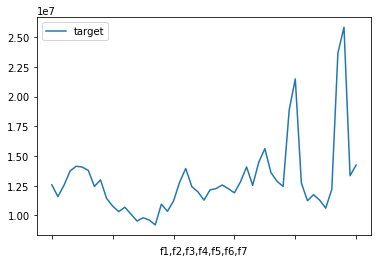

In [36]:
data.plot()

### Here we have less training samples and also I had taken last 15 data points as test set, which are more uneven(as comparing with 36 samples of train set) as we seen in above figure

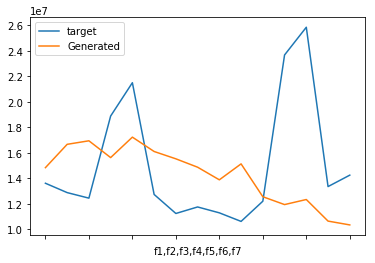

In [37]:
test_set.plot()

# Thank you....!